In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import kstest
from sklearn import preprocessing,model_selection
from sklearn.linear_model import LogisticRegression,LinearRegression,LassoCV
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,mean_squared_error,make_scorer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso




In [2]:
housing_df = pd.read_csv('Melbourne_housing.csv')

In [3]:
housing_df.head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Thornbury,7/67 Pender St,2,u,438000.0,SP,Love,22/08/2016,6.5,3071,...,1.0,1.0,0.0,66.0,1970.0,Darebin City Council,-37.7541,145.0088,Northern Metropolitan,8870
1,Coburg,32 Rose St,2,h,901000.0,S,Peter,27/06/2016,7.8,3058,...,1.0,1.0,545.0,107.0,1940.0,Darebin City Council,-37.7445,144.9471,Northern Metropolitan,11204
2,Bentleigh East,2/25 Brooks St,3,u,800000.0,S,Woodards,28/05/2016,13.9,3165,...,2.0,2.0,261.0,NaN,NaN,Glen Eira City Council,-37.9163,145.0779,Southern Metropolitan,10969
3,Templestowe Lower,2/35 John St,3,t,1155000.0,S,Jellis,25/11/2017,12.4,3107,...,NaN,NaN,NaN,NaN,NaN,Manningham City Council,NaN,NaN,Eastern Metropolitan,5420
4,South Yarra,1/35 Marne St,3,u,1630000.0,PI,Jellis,10/9/2016,3.3,3141,...,1.0,1.0,0.0,NaN,NaN,Melbourne City Council,-37.8359,144.9839,Southern Metropolitan,14887


In [4]:
def clean_data(df):
    df.columns = df.columns.str.replace(' ','_')
    df.columns = df.columns.str.lower()
    # df =  df.dropna() ## if we want to drop all the null values from the dataset
    ## df = df.drop(columns= ['unnamed:_32'])
    
    return df

In [5]:
housing_df =  clean_data(housing_df)

### EDA

<Axes: xlabel='rooms'>

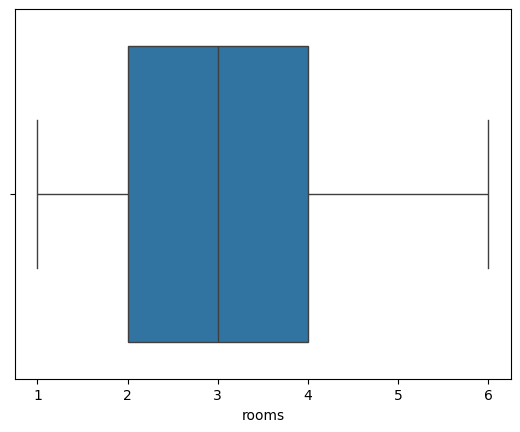

In [6]:
sns.boxplot(x=housing_df["rooms"])

#### we could see that average rooms across all the region is 3. 

<Axes: xlabel='rooms', ylabel='price'>

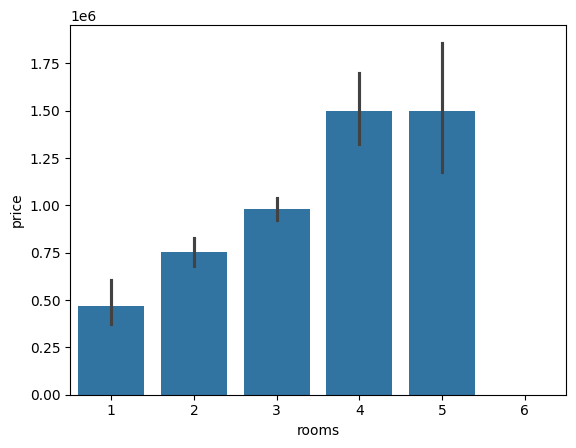

In [7]:
sns.barplot(housing_df, x='rooms', y='price')

#### we could see that from the above plot is that, as the number of rooms increases price of the houses also increases.

<Axes: xlabel='price', ylabel='regionname'>

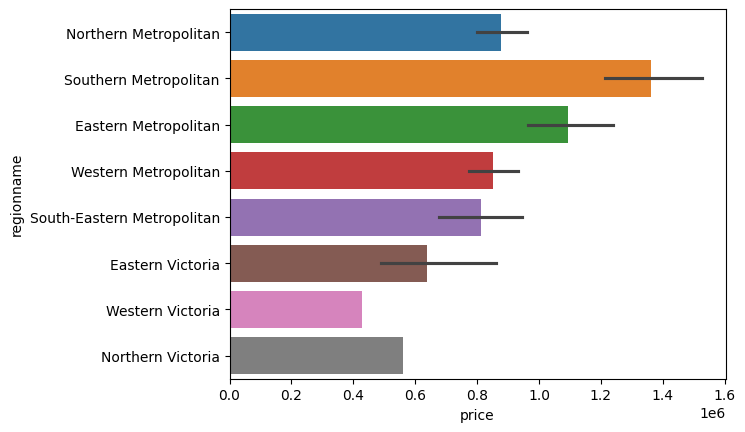

In [8]:
sns.barplot(housing_df, x='price', y='regionname', hue='regionname')

#### Based on the graph above we could see that the southern metropolitan region houses prices are more as compare to other regions. On the other hand we could see that western victoria has the lowest prices.

<Axes: xlabel='rooms', ylabel='bathroom'>

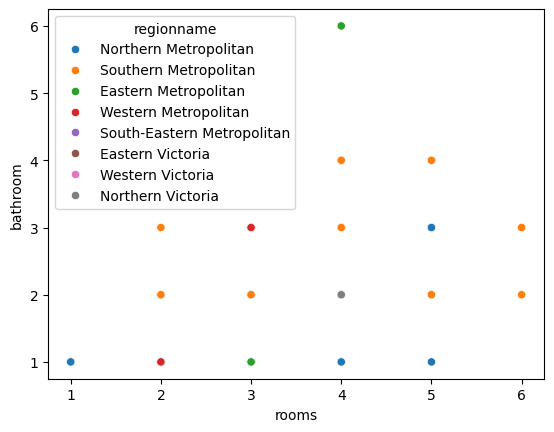

In [9]:
sns.scatterplot(data=housing_df, x="rooms", y="bathroom",hue='regionname')

<Axes: xlabel='yearbuilt', ylabel='Count'>

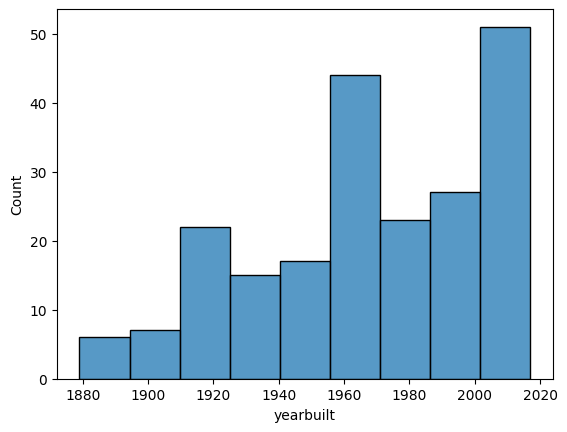

In [10]:
sns.histplot(data=housing_df, x='yearbuilt')

#### There are many houses which are recently built between 2000 to 2020. we could also see that there is a spike in the house built between 1960 to 1970. 

In [11]:
housing_df_correlation_1 = housing_df.select_dtypes(exclude=['object'])
cormat = housing_df_correlation_1.corr()


<Axes: >

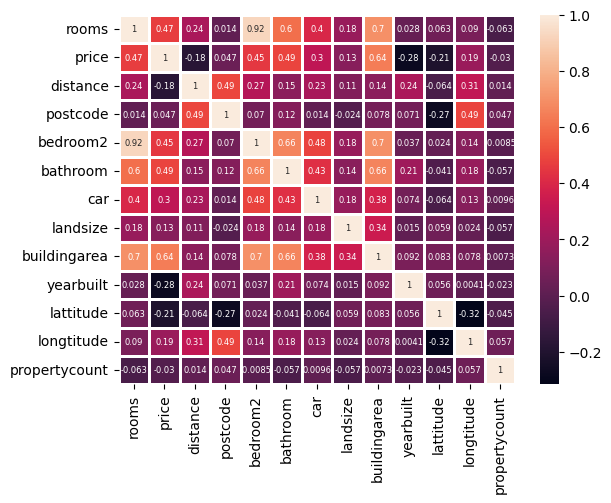

In [12]:
sns.heatmap(cormat, annot=True, linewidths=1, annot_kws={"size":6})

#### From the correlation plot we could extract insight that rooms and bedroom2 are highly correlated with each other. That means they are collinear with each other.

<Axes: xlabel='type', ylabel='price'>

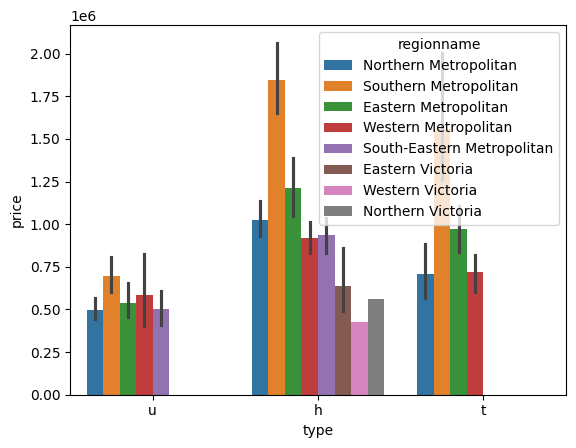

In [13]:
sns.barplot(housing_df, y='price', x='type', hue='regionname')

### Data Preprocess steps: 
1) We have selected few categorical variables like type,regionname and method. We have created the dummy variables for the type and regionname. For the method we have done the label encoding because the number of variables are more in this category. 
2) For handling missing values, we have replace value of columns like('landsize','buildingarea','yearbuilt') with mean value. 
3) For car, we are replacing the null values with zero.
4) For bathroom and bedroom2, we are replacing the value by mode. we have grouped the rooms and postcode then took mode for bedroom and bathroom. Then Replace null value with based on the grouped mode.
5) We have taken all the numerical data and selected categorical variables like type,regionname and method. Rest we have dropped all the columns. 

In [14]:
def dummy_variable(df):
    suburb_dummies = pd.get_dummies(df[['type','regionname']])
    label_encoder = preprocessing.LabelEncoder()
    list_column = ['method']
    for i in list_column:
        df[i] = label_encoder.fit_transform(df[i])
    df = df.select_dtypes(exclude=['object'])
    all_Data = df.join(suburb_dummies)
    return all_Data
    
    

In [15]:
def get_mode(series):
    if len(series.mode()) > 0:
        return series.mode()[0]
    else:
        return np.nan

In [16]:
def handling_missing_value(df):
    '''Handling missing values for different variables'''
    
    ## for price we are drop missing values because it's our dependent variable
    df = df.dropna(subset= 'price')
    
    ## handling values for landsize, buildingarea and yearbuilt 
    ls_ba_yb = ['landsize','buildingarea','yearbuilt']
    for column in ls_ba_yb:
        df[column] = df[column].fillna(df[column].mean())
        

    ## handling values for car, fill null values with 0
    df['car']=df['car'].fillna(0)
    
    
    ## handling values for bathroom and bedroom2
    ## grouping the values of bathroom and bedroom2 based on the rooms and postcode
    grouped_modes = df.groupby(['rooms', 'postcode'])[['bathroom','bedroom2']].agg(get_mode).reset_index()
    df = df.merge(grouped_modes, on=['rooms', 'postcode'], suffixes=('', '_mode'))

    # Fill missing 'bathroom' and 'bedroom2' values with their respective modes
    df['bathroom'] = df['bathroom'].fillna(df['bathroom_mode'])
    df['bedroom2'] = df['bedroom2'].fillna(df['bedroom2_mode'])
    

    # Drop the extra columns
    df = df.drop(['bathroom_mode','lattitude','longtitude','bedroom2_mode'], axis=1)
    
    df['bathroom'] =df['bathroom'].fillna(df['bathroom'].mode()[0])
    df['bedroom2'] =df['bedroom2'].fillna(df['bedroom2'].mode()[0])
    
        
    
    return df
    
    

In [17]:
housing_df_correlation_new   = dummy_variable(housing_df) 
housing_df_new = handling_missing_value(housing_df_correlation_new)
housing_df_new.replace({False: 0, True: 1}, inplace=True)


/var/folders/q8/ljm60kbj15sdr2ljq0vcfbq00000gn/T/ipykernel_58289/1383359986.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(df[column].mean())
/var/folders/q8/ljm60kbj15sdr2ljq0vcfbq00000gn/T/ipykernel_58289/1383359986.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['car']=df['car'].fillna(0)


In [18]:
def extract_x_y_variable(df):
    df["price"] = np.log1p(df["price"])
    x_var = df.drop(columns=['price'])
    y_var = df['price']
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_var)
    
    return x_var,y_var

In [19]:
x_var,y_var = extract_x_y_variable(housing_df_new)

In [20]:
x_train,x_test, y_stat_train,y_stat_test = model_selection.train_test_split(x_var,y_var,test_size= 0.3)

### Linear Regression

In [21]:
lr = LinearRegression()

#Fit model
lr.fit(x_train, y_stat_train)

prediction = lr.predict(x_test)
prediction_train = lr.predict(x_train)



### Model Evaluation 

In [22]:
r2_score_train =  r2_score(y_stat_train,prediction_train)
rmse_lr_train = np.sqrt(mean_squared_error(y_stat_train,prediction_train))

In [23]:
print("RMSE Train ={}".format(rmse_lr_train))
print("R_square Train ={}".format(r2_score_train))


RMSE Train =0.2661522964191258
R_square Train =0.7499180877308844


In [24]:
r2_score_lr_test =  r2_score(y_stat_test,prediction)
rmse_lr_test = np.sqrt(mean_squared_error(y_stat_test,prediction))

In [25]:
print("RMSE Test ={}".format(rmse_lr_test))
print("R_square Test ={}".format(r2_score_lr_test))


RMSE Test =0.3063327369533968
R_square Test =0.6297872737958863


##### Based on the above metrics, we can see that model is performing well for both the train and test set. We could see that rsquare is pretty good and RMSE is also very consistant 

### Lasso Regression 

In [50]:
lasso = Lasso(alpha=0.001)
lasso.fit(x_train,y_stat_train)
y_pred_train_lasso = lasso.predict(x_train)
y_pred_test = lasso.predict(x_test)

### Lasso regression Evaluation

In [51]:
r2_score_lasso_train = r2_score(y_stat_train,y_pred_train_lasso)
rmse_lasso_train = np.sqrt(mean_squared_error(y_stat_train,y_pred_train_lasso))


In [52]:
r2_score_lasso_test = r2_score(y_stat_test,y_pred_test)
rmse_lasso_test = np.sqrt(mean_squared_error(y_stat_test,y_pred_test))


In [53]:
print("RMSE Train ={}".format(rmse_lasso_train))
print("R_square Train ={}".format(r2_score_lasso_train))
print("RMSE Test ={}".format(r2_score_lasso_test))
print("R_square Test ={}".format(rmse_lasso_test))



RMSE Train =0.26687033897835577
R_square Train =0.7485668938042437
RMSE Test =0.6309311625385493
R_square Test =0.305859115114649


#### We can see that model is performing well for training data. But when we see the testing data performance we could see that it has drastically gone down for both rmse and r_square. This tell us that we are overfitting our model. 

### Out of sample performance 

In [30]:
## spliting the data into 80 percent training data and 20 percent test data
x_new_train,x_new_test, y_new_train,y_new_test = model_selection.train_test_split(x_var,y_var,test_size= 0.2)

In [31]:
#Fit model
lr.fit(x_new_train, y_new_train)
prediction_new_train = lr.predict(x_new_train)
rss = np.sum((y_new_train - prediction_new_train) ** 2)
n = len(y_new_test)
k = x_new_train.shape[1] + 1  # Number of parameters including the intercept
aic_train = n * np.log( n / rss ) + 2 * k
aicc_train = n * np.log( n / rss ) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)
bic_train = n * np.log( rss / n  ) + k * np.log(n)






In [32]:
r2_score_new_train =  r2_score(y_new_train,prediction_new_train)
rmse_lr_new_train = np.sqrt(mean_squared_error(y_new_train,prediction_new_train))


In [33]:
print("RMSE Train ={}".format(rmse_lr_new_train))
print("R_square Train ={}".format(r2_score_new_train))
print("aic= {}".format(aic_train))
print("aicc= {}".format(aicc_train))
print("bic= {}".format(bic_train))



RMSE Train =0.25294149008494077
R_square Train =0.7568639341085326
aic= 154.67546738285557
aicc= 174.74819465558284
bic= -8.178166776114082


#### cross fold validation

In [34]:
KFold = 5
rmse_reduced_train = cross_val_score(lr,x_new_train,y_new_train,cv=KFold,scoring='neg_mean_squared_error')
rmse_reduced_train = np.sqrt(-rmse_reduced_train)
rmse_reduced_train = rmse_reduced_train.mean()
print("Average rmse Train model  ={}".format(rmse_reduced_train))



Average rmse Train model  =0.2767034983106086


### Lasso (Out of sample performance)

In [35]:
#Fit model for Lasso regression
lasso_new = Lasso(alpha= 0.0001)
lasso_new.fit(x_new_train,y_new_train)
y_pred_lasso_train = lasso_new.predict(x_new_train)
rss = np.sum((y_new_train - y_pred_lasso_train) ** 2)
n = len(y_new_test)
k = x_new_train.shape[1] + 1  # Number of parameters including the intercept
aic_train_lasso = n * np.log( n / rss ) + 2 * k
aicc_train_lasso = n * np.log( n / rss ) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)
bic_train_lasso = n * np.log( rss / n  ) + k * np.log(n)



In [36]:
r2_score_new_train =  r2_score(y_new_train,y_pred_lasso_train)
rmse_lr_new_train = np.sqrt(mean_squared_error(y_new_train,y_pred_lasso_train))


In [37]:
print("RMSE Train ={}".format(rmse_lr_new_train))
print("R_square Train ={}".format(r2_score_new_train))
print("aic= {}".format(aic_train_lasso))
print("aicc= {}".format(aicc_train_lasso))
print("bic= {}".format(aicc_train_lasso))



RMSE Train =0.2529532531549466
R_square Train =0.7568413194472052
aic= 154.66811974745872
aicc= 174.74084702018598
bic= 174.74084702018598


#### cross fold validation

In [38]:
lasso_cv = LassoCV(cv=5).fit(x_new_train, y_new_train)
cv_scores_lasso = lasso_cv.mse_path_.mean(axis=1)

rmse_cv_lasso = np.sqrt(cv_scores_lasso.mean())

In [39]:
print("Average rmse Train model lasso using cross validation  ={}".format(rmse_reduced_train))

Average rmse Train model lasso using cross validation  =0.2767034983106086


### OOS performance


#### Linear Regression test

In [40]:
prediction_new_test = lr.predict(x_new_test)
rss = np.sum((y_new_test - prediction_new_test) ** 2)
n = len(y_new_test)
k = x_new_train.shape[1] + 1  # Number of parameters including the intercept
aic_test = n * np.log( n / rss ) + 2 * k
aicc_test = n * np.log( n / rss ) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)
bic_test = n * np.log( rss / n  ) + k * np.log(n)

In [54]:
r2_score_lr_new__test =  r2_score(y_new_test,prediction_new_test)
rmse_lr_new_test = rmse_linear = np.sqrt(mean_squared_error(y_new_test,prediction_new_test))

In [55]:
print("RMSE Test ={}".format(rmse_lr_new_test))
print("R_square Test ={}".format(r2_score_lr_new__test))
print("aic test = {}".format(aic_test))
print("aicc test= {}".format(aicc_test))
print("bic test= {}".format(bic_test))


RMSE Test =0.3644894086662688
R_square Test =0.5688388018251569
aic test = 205.46273004779152
aicc test= 225.5354573205188
bic test= -58.965429441050034


In [ ]:

print("Testing Dataset")
rmse_reduced = cross_val_score(lr,x_new_test,y_new_test,cv=KFold,scoring='neg_mean_squared_error')
rmse_reduced = np.sqrt(-rmse_reduced)
rmse_reduced = rmse_reduced.mean()
print("Average rmse Test model={}".format(rmse_reduced))


Testing Dataset
Average rmse Test model=0.37530714707293195


#### Lasso 

In [ ]:

prediction_new_lasso_test = lasso_new.predict(x_new_test)
rss = np.sum((y_new_test - prediction_new_lasso_test) ** 2)
n = len(y_new_test)
k = x_new_train.shape[1] + 1  # Number of parameters including the intercept
aic_test_lasso = n * np.log( n / rss ) + 2 * k
aicc_test_lasso = n * np.log( n / rss ) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)
bic_test_lasso = n * np.log( rss / n  ) + k * np.log(n)
r2_score_new_test=  r2_score(y_new_test,prediction_new_lasso_test)
rmse_lr_new_test = np.sqrt(mean_squared_error(y_new_test,prediction_new_lasso_test))


In [ ]:
print("RMSE Train ={}".format(rmse_lr_new_test))
print("R_square Train = {}".format(r2_score_new_test))
print("aic test lasso = {}".format(aic_test_lasso))
print("aicc test lasso = {}".format(aicc_test_lasso))
print("bictest lasso = {}".format(bic_test_lasso))



RMSE Train =0.29270059206122334
R_square Train =0.7122683313735878
aic= 240.11959987950152
aicc= 260.1923271522288
bic= -93.62229927276003


In [56]:
lasso_cv = LassoCV(cv=5).fit(x_new_test, y_new_test)
cv_scores_lasso = lasso_cv.mse_path_.mean(axis=1)

rmse_cv_lasso_test = np.sqrt(cv_scores_lasso.mean())
print("Average rmse Test model lasso using cross validation  ={}".format(rmse_cv_lasso_test))

Average rmse Test model lasso using cross validation  =0.5400251460585961


#### When We see Ics of the model, we could see that bic is negative for linear regression but for lasso we could see that it has positive for train data but negative for test data which is typically unusual because this tell us that log-likelihood has greater value than the penalty. 
#### Aic and Bic are more closer to zero, better the model, this means that linear regression is  better  as compare to lasso

####  Based on the above metrics, we could say that lasso has performed well for OOS in both rmse and r squares. But when check rmse for the cross validation, it tells us that linear regression has done better on the unseen data. 